# Implementing the model based in the paper \[[1](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10404993&casa_token=bdWYvtDCImwAAAAA:dEnW6U7EsqgOzYXmVphWYMTQ7XySynoAB-mU9Hq0NVxpyvBfB_ML1mlJEmmeIfK2b59TxZsoxg&tag=1)\]

[1] [Zhong, Yongchao, et al. "Sybil Attack Detection in VANETs: An LSTM-Based BiGAN Approach." 2023 International Conference on Data Security and Privacy Protection (DSPP). IEEE, 2023.](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10404993&casa_token=bdWYvtDCImwAAAAA:dEnW6U7EsqgOzYXmVphWYMTQ7XySynoAB-mU9Hq0NVxpyvBfB_ML1mlJEmmeIfK2b59TxZsoxg&tag=1)

In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.io as scio

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

from sys import path 
path.append("../utils")
from dataset_operations import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-06-14 02:29:41.361551: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 02:29:41.417291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 02:29:41.417342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 02:29:41.418831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-14 02:29:41.427116: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 02:29:42.727796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

# Load Dataset \[[2](https://github.com/stevenso8/WiSec_DataModifiedVeremi_Dataset)\]

[2] [WiSec_DataModifiedVeremi_Dataset](https://github.com/stevenso8/WiSec_DataModifiedVeremi_Dataset)

In [6]:
dataset_1 = scio.loadmat('../datasets/Modified_VeReMi/WiSec_DataModifiedVeremi_Dataset/attack16withlabels.mat')
dataset_2 = scio.loadmat('../datasets/Modified_VeReMi/WiSec_DataModifiedVeremi_Dataset/attack1withlabels.mat')
dataset_3 = scio.loadmat('../datasets/Modified_VeReMi/WiSec_DataModifiedVeremi_Dataset/attack2withlabels.mat')
dataset_4 = scio.loadmat('../datasets/Modified_VeReMi/WiSec_DataModifiedVeremi_Dataset/attack4withlabels.mat')
dataset_5 = scio.loadmat('../datasets/Modified_VeReMi/WiSec_DataModifiedVeremi_Dataset/attack8withlabels.mat')

# Dataset Visualization

In [7]:
header = ["type",
         "timeReceiver",
         "receiverID",
         "receiverXposition",
         "receiverYposition",
         "receiverZposition",
         "timeTransmitted",
         "senderID",
         "messageID",
         "senderXposition",
         "senderYposition",
         "senderZposition",
         "senderXvelocity",
         "senderYvelocity",
         "senderZvelocity",
         "rssi",
         "class"]

df_dataset = pd.concat([pd.DataFrame(dataset_1['attack16withlabels']),
               pd.DataFrame(dataset_2['attack1withlabels']),
               pd.DataFrame(dataset_3['attack2withlabels']),
               pd.DataFrame(dataset_4['attack4withlabels']),
               pd.DataFrame(dataset_5['attack8withlabels'])])

df_dataset.columns = header

# verify the number of missing data
df_dataset.isna().sum()

type                      0
timeReceiver              0
receiverID                0
receiverXposition         0
receiverYposition         0
receiverZposition         0
timeTransmitted           0
senderID                  0
messageID                 0
senderXposition           0
senderYposition           0
senderZposition           0
senderXvelocity      190729
senderYvelocity      190729
senderZvelocity      190729
rssi                      0
class                     0
dtype: int64

In [25]:
len(df_dataset[df_dataset['class'] == 0])/len(df_dataset['class'])

0.6914361045916833

# Feature Pre-Processing

 1 - Removing identifiers\
 2 - Handling missing values\
 3 - Person correlation\
 4 - Feature normalization (minmax scaler)

### 1 - Removing identifiers

In [4]:
 df_dataset = df_dataset.drop(['receiverID','senderID', 'messageID'], axis=1)

df_dataset

,type,timeReceiver,receiverXposition,receiverYposition,receiverZposition,timeTransmitted,senderXposition,senderYposition,senderZposition,senderXvelocity,senderYvelocity,senderZvelocity,rssi,class
0,3.0,21903.585423,6120.665658,6061.127336,1.895,21903.585309,6128.152273,5821.906957,1.895,-0.000000,-0.000000,0.0,5.010526e-09,0.0
1,3.0,21903.631327,6122.031744,6060.660868,1.895,21903.631209,6121.684406,5821.255358,1.895,-0.000000,-0.000000,0.0,1.306551e-08,0.0
2,3.0,21903.881714,6124.764066,6059.732188,1.895,21903.881599,6114.221634,5820.503528,1.895,NaN,NaN,NaN,1.693369e-08,0.0
3,3.0,21903.883905,6124.764066,6059.732188,1.895,21903.883787,6175.757050,5826.702852,1.895,NaN,NaN,NaN,1.632938e-09,16.0
4,3.0,21904.590443,6134.329500,6056.489708,1.895,21904.590327,4459.551992,6008.611637,1.895,13.107548,1.134284,0.0,5.772479e-09,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424805,3.0,21727.043804,3593.686413,6054.876581,1.895,21727.043696,3605.071868,5570.490948,1.895,2.672805,-31.749509,0.0,1.538509e-09,0.0
424806,3.0,21727.058410,3593.686413,6054.876581,1.895,21727.058295,3785.214659,5327.292058,1.895,-2.578585,31.477719,0.0,1.869508e-09,8.0
424807,3.0,21727.285690,3594.500824,6062.578667,1.895,21727.285582,3592.858096,5707.163275,1.895,1.440261,-33.508116,0.0,8.109659e-09,0.0
424808,3.0,21727.401015,3595.314628,6070.275010,1.895,21727.400896,3598.485041,5653.011439,1.895,1.445222,-33.653966,0.0,5.112538e-09,0.0


### 2 - Handling missing values

In [5]:
df_dataset = df_dataset.dropna()

df_dataset

,type,timeReceiver,receiverXposition,receiverYposition,receiverZposition,timeTransmitted,senderXposition,senderYposition,senderZposition,senderXvelocity,senderYvelocity,senderZvelocity,rssi,class
0,3.0,21903.585423,6120.665658,6061.127336,1.895,21903.585309,6128.152273,5821.906957,1.895,-0.000000,-0.000000,0.0,5.010526e-09,0.0
1,3.0,21903.631327,6122.031744,6060.660868,1.895,21903.631209,6121.684406,5821.255358,1.895,-0.000000,-0.000000,0.0,1.306551e-08,0.0
4,3.0,21904.590443,6134.329500,6056.489708,1.895,21904.590327,4459.551992,6008.611637,1.895,13.107548,1.134284,0.0,5.772479e-09,16.0
6,3.0,21904.631316,6135.696106,6056.026458,1.895,21904.631209,6121.684406,5821.255358,1.895,-0.000000,-0.000000,0.0,2.799100e-09,0.0
11,3.0,21905.450230,6146.624725,6052.321887,1.895,21905.450117,5949.930035,5709.128708,1.895,-14.117720,-1.799463,0.0,6.594317e-09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424805,3.0,21727.043804,3593.686413,6054.876581,1.895,21727.043696,3605.071868,5570.490948,1.895,2.672805,-31.749509,0.0,1.538509e-09,0.0
424806,3.0,21727.058410,3593.686413,6054.876581,1.895,21727.058295,3785.214659,5327.292058,1.895,-2.578585,31.477719,0.0,1.869508e-09,8.0
424807,3.0,21727.285690,3594.500824,6062.578667,1.895,21727.285582,3592.858096,5707.163275,1.895,1.440261,-33.508116,0.0,8.109659e-09,0.0
424808,3.0,21727.401015,3595.314628,6070.275010,1.895,21727.400896,3598.485041,5653.011439,1.895,1.445222,-33.653966,0.0,5.112538e-09,0.0


### 3 - Pearson Correlation

In [6]:
features_nan_corr = ["receiverZposition",
                     "senderZposition",
                     "type",
                     "senderZvelocity",
                     "timeReceiver"]

df_dataset = df_dataset.drop(columns=features_nan_corr)

<Axes: >

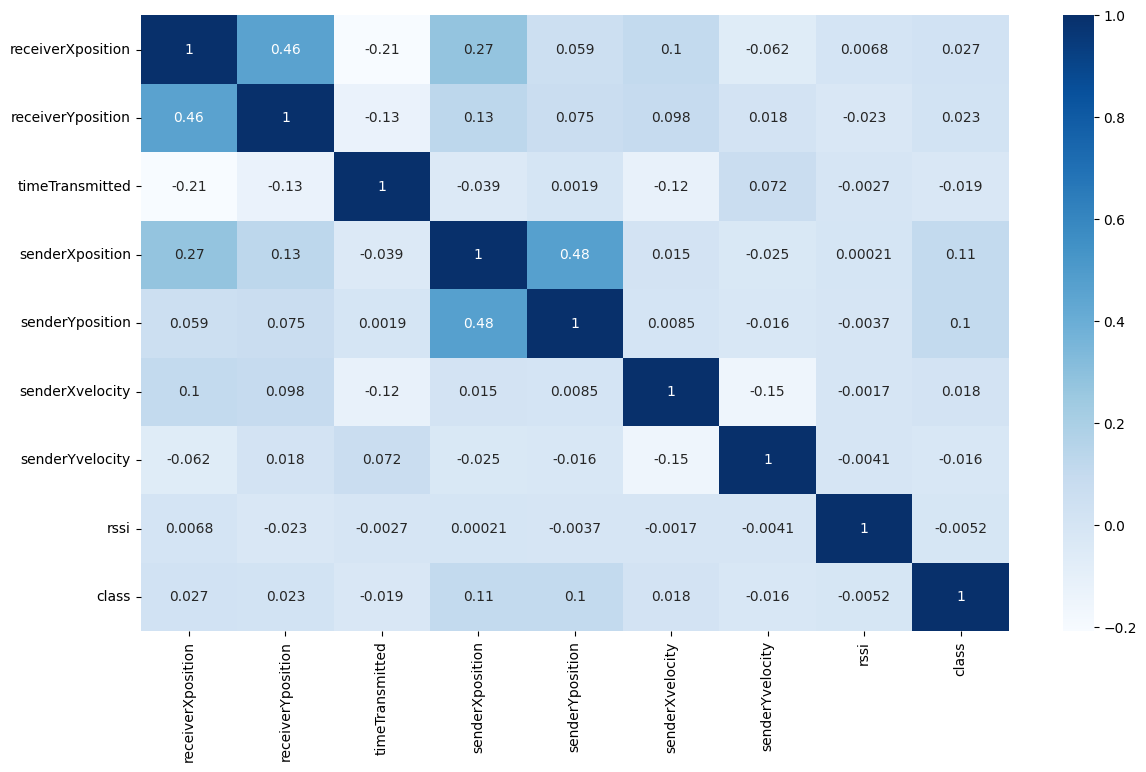

In [7]:
plt.figure(figsize=(14,8))
sns.heatmap(df_dataset.corr(), annot=True, cmap='Blues')

### 4 - Feature normalization

In [8]:
X = df_dataset.drop(columns=['class'])

In [9]:
columns_names = X.columns
scaler = MinMaxScaler()
scaler = scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = columns_names
X

,receiverXposition,receiverYposition,timeTransmitted,senderXposition,senderYposition,senderXvelocity,senderYvelocity,rssi
0,0.948911,0.979039,0.843297,0.224636,0.252893,0.495466,0.475059,1.568228e-06
1,0.949253,0.978520,0.843424,0.224399,0.252865,0.495466,0.475059,4.944727e-06
2,0.952327,0.973886,0.846088,0.163467,0.261014,0.656288,0.487234,1.887624e-06
3,0.952669,0.973371,0.846202,0.224399,0.252865,0.495466,0.475059,6.412393e-07
4,0.955402,0.969254,0.848477,0.218102,0.247988,0.322251,0.455744,2.232123e-06
...,...,...,...,...,...,...,...,...
1936242,0.317100,0.972093,0.352901,0.132143,0.241957,0.528260,0.134261,1.128228e-07
1936243,0.317100,0.972093,0.352941,0.138746,0.231379,0.463829,0.812940,2.515714e-07
1936244,0.317304,0.980651,0.353573,0.131695,0.247902,0.513137,0.115384,2.867326e-06
1936245,0.317507,0.989203,0.353893,0.131901,0.245547,0.513198,0.113818,1.610989e-06


# Generating Labels One-Hot Enconding

In [16]:
y = df_dataset['class']
y = pd.get_dummies(y,columns=['class'])
y.shape

(1936247, 6)

# Format data

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.8,random_state=42)
x_train = np.resize(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.resize(x_test,(x_test.shape[0],1,x_test.shape[1]))

# Model Implementation

In [12]:
model = Sequential()
model.add(LSTM(100, activation='tanh',return_sequences=True,input_shape=(None,X.shape[1])))
model.add(LSTM(49,activation='tanh'))
model.add(Dense(6,activation='softmax'))

model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

2024-06-12 14:36:34.765417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 14:36:34.765625: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/lcastrod/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  s

# Model Training

In [13]:
model.fit(x_train,y_train,epochs=500,batch_size=64)

Epoch 1/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 6s 793us/step - accuracy: 0.7599 - loss: 0.9199
Epoch 2/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 818us/step - accuracy: 0.8117 - loss: 0.6484
Epoch 3/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 843us/step - accuracy: 0.8259 - loss: 0.5729
Epoch 4/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 846us/step - accuracy: 0.8420 - loss: 0.5169
Epoch 5/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 848us/step - accuracy: 0.8609 - loss: 0.4615
Epoch 6/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 853us/step - accuracy: 0.8750 - loss: 0.4210
Epoch 7/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 857us/step - accuracy: 0.8847 - loss: 0.3922
Epoch 8/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 899us/step - accuracy: 0.8928 - loss: 0.3699
Epoch 9/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 870us/step - accuracy: 0.8985 - loss: 0.3509
Epoch 10/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 868us/step - accuracy: 0.9022 - loss: 0.3381
Epoch 11/500
6051/6051 ━━━━━━━━━━━━━━━━━━━━ 5s 882us/step - accuracy: 0.9046 - loss: 0.32

# Model Test

In [14]:
model.evaluate(x_test,y_test)

48407/48407 ━━━━━━━━━━━━━━━━━━━━ 33s 681us/step - accuracy: 0.9591 - loss: 0.1496


[0.14995211362838745, 0.9588527679443359]

# Model Paramters

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 100)      │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 49)             │        29,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,602 (572.67 KB)

 Trainable params: 73,300 (286.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 73,302 (286.34 KB)